In [1]:
%matplotlib inline

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import math

In [3]:
print(torch.__version__)

1.0.0


In [2]:
#To determine if your system supports CUDA
print("==> Check devices..")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)

#Also can print your current GPU id, and the number of GPUs you can use.
print("Our selected device: ", torch.cuda.current_device())
print(torch.cuda.device_count(), " GPUs is available")
#device = 'cpu'

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


In [4]:
#The transform function for train data
transform_train = transforms.transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [5]:
"""1.2""" 
path = '../data/mnist_data'
trainset = torchvision.datasets.MNIST(root=path, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.MNIST(root=path, train=False, download=True, transform=transform_test)

In [206]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

In [207]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [208]:
import torch.nn as nn

In [209]:
#Lab requirement:
#    All weights are zero
#    Uniform distribution (-1, 1)
#    Normal distribution, mean = 0 & standard deviation = 0.1
#    Xavier initialization
#    Kaiming initialization

In [210]:
# define your own model
class Net(nn.Module):

    #define the layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        #self.relu = nn.PReLU()

    #concatenate these layers
    def forward(self, x):
        # input is 28x28x1
        # conv1(kernel=5, filters=10) 28x28x10 -> 24x24x10
        # max_pool(kernel=2) 24x24x10 -> 12x12x10

        x = self.relu(self.pool(self.conv1(x)))
        
        # conv2(kernel=5, filters=20) 12x12x20 -> 8x8x20
        # max_pool(kernel=2) 8x8x20 -> 4x4x20

        x = self.relu(self.pool(self.dropout(self.conv2(x))))
        #x = self.relu(self.pool(self.conv2(x)))
        
        # flatten 4x4x20 = 320
        x = x.view(-1, 320)

        # 320 -> 50
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        # 50 -> 10
        x = self.relu(self.fc2(x))
        return x

In [211]:
def init_weights_constant(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)
        
def init_weights_uniform(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -0.1, 0.1)

def init_weights_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)

def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, a=0.5, mode='fan_out', nonlinearity='relu')           
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.1, mode='fan_out', nonlinearity='relu')           

def init_weights_original(m):
    return


In [212]:
def construct_net(mode):
    #declare a new model
    net = Net()
    if(mode == 'constant'):
        print('constant mode')
        init_func = init_weights_constant
    elif(mode == 'uniform'):
        print('uniform mode')
        init_func = init_weights_uniform
    elif(mode == 'normal'):
        print('normal mode')
        init_func = init_weights_normal
    elif(mode == 'xavier'):
        print('xavier mode')
        init_func = init_weights_xavier
    elif(mode == 'kaiming'):
        print('kaiming mode')
        init_func = init_weights_kaiming
    else:
        print('original mode')
        init_func = init_weights_original
    
    net.apply(init_func)
    # change all model tensor into cuda type
    # something like weight & bias are the tensor 
    if device == 'cuda':
        net = net.cuda(0)
    else:
        net = net.cpu()
    
    return net

In [213]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def show_weight_distribution(net, batch):
    n_bins = 50
    font_size = 8
    plt.rcParams.update({'axes.titlesize': font_size})
    plt.rcParams.update({'axes.labelsize': font_size})
    plt.rcParams.update({'xtick.labelsize': font_size})
    plt.rcParams.update({'ytick.labelsize': font_size})
    fig, axs = plt.subplots(1, 4, sharey=True)
    
    x = net.conv1.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 1)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv1')
    plt.title('Weight Distribution, batch: %d' %(batch))

    x = net.conv2.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 2)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv2')

    x = net.fc1.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 3)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc1')

    x = net.fc2.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 4)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc2')

    plt.show()

In [214]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def show_bias_distribution(epoch):
    n_bins = 50
    font_size = 8
    plt.rcParams.update({'axes.titlesize': font_size})
    plt.rcParams.update({'axes.labelsize': font_size})
    plt.rcParams.update({'xtick.labelsize': font_size})
    plt.rcParams.update({'ytick.labelsize': font_size})
    fig, axs = plt.subplots(1, 4, sharey=True)
    
    x = net.conv1.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 1)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv1')
    plt.title('Bias Distribution, epoch: %d' %(epoch))

    x = net.conv2.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 2)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv2')

    x = net.fc1.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 3)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc1')

    x = net.fc2.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 4, 4)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc2')

    plt.show()

In [215]:
#Set the model in training mode
#because some function like: dropout, batchnorm...etc, will have 
#different behaviors in training/evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train
import torch.optim as optim

def train(net):

    #loss function
    criterion = nn.CrossEntropyLoss()
    #optimization algorithm
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
    
    net.train()

    for epoch in range(1):  # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0

        show_weight_distribution(net, 0)
        for i, (inputs, labels) in enumerate(trainloader, 0):
        
            #change the type into cuda tensor 
            if device == 'cuda':
                inputs = inputs.cuda(0)
                labels = labels.cuda(0)
            else:
                inputs = inputs.cpu()
                labels = labels.cpu()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # select the class with highest probability
            _, pred = outputs.max(1)
            # if the model predicts the same results as the true
            # label, then the correct counter will plus 1
            correct += pred.eq(labels).sum().item()
        
            loss = criterion(outputs, labels)
        
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] accuracy: %.2f%% loss: %.3f' %
                    (epoch + 1, i + 1, 100.*correct/len(trainset), running_loss / 200))
                running_loss = 0.0
                show_weight_distribution(net, i + 1)
            
        print('%d epoch, training accuracy: %.2f%%' % (epoch+1, 100.*correct/len(trainset)))
    print('Finished Training')

In [216]:
#show_weight_distribution(50)
#show_bias_distribution(50)

In [217]:
#save entire model
#torch.save(net, './mnist-model.pt')
#print('Finished Saving')

In [218]:
#net = torch.load('./mnist-model.pt')
#print('Finished Loading')

In [219]:
#print('==> Testing model..')
#net.eval()

In [220]:
def test(net):
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total = 0
    running_loss = 0.0

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in testloader:
            images, labels = data

            if device == 'cuda':
                images = images.cuda(0)
                labels = labels.cuda(0)
            else:
                images = images.cpu()
                labels = labels.cpu()
        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            c = (predicted == labels).squeeze()
            #print(predicted)
            #print(labels.size(0))
            #print(c)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
          % (total, 100 * correct / total, running_loss / total))

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

constant mode


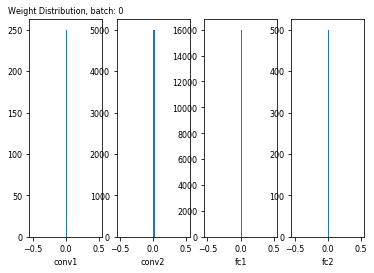

1 epoch, training accuracy: 22.51%
Finished Training
Accuracy of the network on the 10000 test images: 26.96%, and loss is: 0.002
Accuracy of     0 : 91 %
Accuracy of     1 :  0 %
Accuracy of     2 :  0 %
Accuracy of     3 : 88 %
Accuracy of     4 : 90 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  0 %
Accuracy of     8 :  1 %
Accuracy of     9 :  0 %


In [227]:
new_net = construct_net('constant')
train(new_net)
test(new_net)

uniform mode


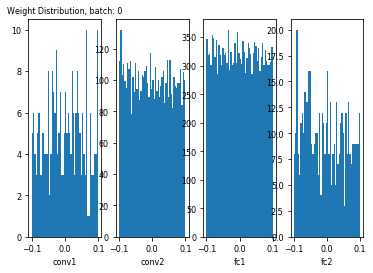

1 epoch, training accuracy: 80.10%
Finished Training
Accuracy of the network on the 10000 test images: 92.66%, and loss is: 0.000
Accuracy of     0 : 97 %
Accuracy of     1 : 96 %
Accuracy of     2 : 92 %
Accuracy of     3 : 95 %
Accuracy of     4 : 92 %
Accuracy of     5 : 89 %
Accuracy of     6 : 91 %
Accuracy of     7 : 91 %
Accuracy of     8 : 90 %
Accuracy of     9 : 88 %


In [228]:
new_net = construct_net('uniform')
train(new_net)
test(new_net)

normal mode


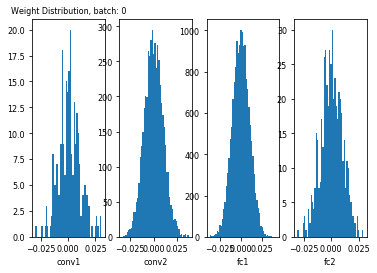

1 epoch, training accuracy: 64.23%
Finished Training
Accuracy of the network on the 10000 test images: 82.81%, and loss is: 0.000
Accuracy of     0 : 90 %
Accuracy of     1 : 95 %
Accuracy of     2 : 81 %
Accuracy of     3 : 81 %
Accuracy of     4 : 88 %
Accuracy of     5 : 83 %
Accuracy of     6 : 88 %
Accuracy of     7 : 82 %
Accuracy of     8 : 78 %
Accuracy of     9 : 56 %


In [229]:
new_net = construct_net('normal')
train(new_net)
test(new_net)

xavier mode


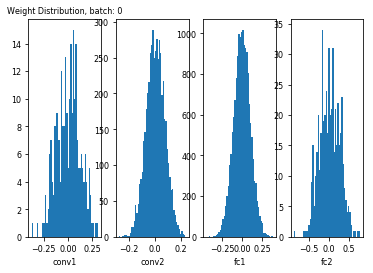

1 epoch, training accuracy: 32.44%
Finished Training
Accuracy of the network on the 10000 test images: 61.77%, and loss is: 0.001
Accuracy of     0 : 81 %
Accuracy of     1 : 83 %
Accuracy of     2 : 63 %
Accuracy of     3 : 56 %
Accuracy of     4 : 52 %
Accuracy of     5 : 33 %
Accuracy of     6 : 73 %
Accuracy of     7 : 61 %
Accuracy of     8 : 61 %
Accuracy of     9 : 45 %


In [230]:
new_net = construct_net('xavier')
train(new_net)
test(new_net)

kaiming mode


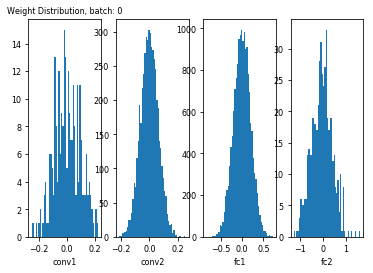

1 epoch, training accuracy: 25.27%
Finished Training
Accuracy of the network on the 10000 test images: 45.09%, and loss is: 0.002
Accuracy of     0 : 86 %
Accuracy of     1 : 88 %
Accuracy of     2 : 42 %
Accuracy of     3 :  8 %
Accuracy of     4 :  1 %
Accuracy of     5 : 57 %
Accuracy of     6 : 82 %
Accuracy of     7 :  0 %
Accuracy of     8 : 12 %
Accuracy of     9 : 69 %


In [233]:
new_net = construct_net('kaiming')
train(new_net)
test(new_net)

original mode


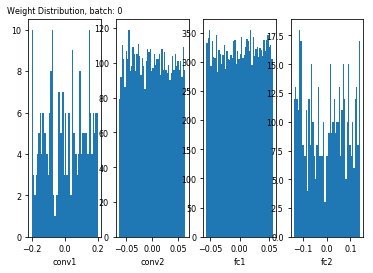

1 epoch, training accuracy: 72.67%
Finished Training
Accuracy of the network on the 10000 test images: 90.53%, and loss is: 0.000
Accuracy of     0 : 91 %
Accuracy of     1 : 96 %
Accuracy of     2 : 92 %
Accuracy of     3 : 92 %
Accuracy of     4 : 91 %
Accuracy of     5 : 87 %
Accuracy of     6 : 93 %
Accuracy of     7 : 87 %
Accuracy of     8 : 89 %
Accuracy of     9 : 83 %


In [232]:
new_net = construct_net('')
train(new_net)
test(new_net)